# Reddit Wall Street Bets Sentiment Analysis

<img src="../images/reddit.jpg">

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import re
import plotly.express as px

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from matplotlib.pyplot import figure

### Data Cleaning / Text Preprocessing

In [145]:
df = pd.read_csv('../reddit_wsb.csv')

In [188]:
df_gme = pd.read_csv('../gme.csv')

In [190]:
df.head(5)

,title,score,comms_num,body,timestamp,title_cleaned,body_cleaned
0,"It's not about the money, it's about sending a...",55,6,NaN,2021-01-28 21:37:41,money send message,nan
1,Math Professor Scott Steiner says the numbers ...,110,23,NaN,2021-01-28 21:32:10,math professor scott steiner say number spell ...,nan
2,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35,exit system,ceo nasdaq push halt trade give investor chanc...
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74,NaN,2021-01-28 21:28:57,new sec file gme someon less retard pleas inte...,nan
4,"Not to distract from GME, just thought our AMC...",71,156,NaN,2021-01-28 21:26:56,distract gme thought amc brother awar thi,nan


In [191]:
df_gme.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/29/2021,379.709991,413.980011,250.000000,325.000000,325.000000,50566100
1,2/1/2021,316.559998,322.000000,212.000000,225.000000,225.000000,37382200
2,2/2/2021,140.759995,158.000000,74.220001,90.000000,90.000000,78183100
3,2/3/2021,112.010002,113.400002,85.250000,92.410004,92.410004,42698500
4,2/4/2021,91.190002,91.500000,53.330002,53.500000,53.500000,62427300


In [147]:
# Drop unnecessary columns for analysis
df = df.drop(columns=['id', 'url', 'created'])

In [192]:
df_gme = df_gme.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])

In [148]:
# Handle missing values
df.isnull().sum()

title            0
score            0
comms_num        0
body         24385
timestamp        0
dtype: int64

In [193]:
df_gme.isnull().sum()

Date         0
Adj Close    0
dtype: int64

In [194]:
# Information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46020 entries, 0 to 46019
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          46020 non-null  object
 1   score          46020 non-null  int64 
 2   comms_num      46020 non-null  int64 
 3   body           21635 non-null  object
 4   timestamp      46020 non-null  object
 5   title_cleaned  46020 non-null  object
 6   body_cleaned   46020 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.5+ MB


In [195]:
df_gme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       62 non-null     object 
 1   Adj Close  62 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [196]:
# Describe dataset
df.describe()

,score,comms_num
count,46020.000000,46020.000000
mean,1460.640026,242.780595
std,8439.574089,2577.133269
min,0.000000,0.000000
25%,1.000000,2.000000
50%,32.000000,14.000000
75%,194.000000,52.000000
max,348241.000000,93268.000000


In [197]:
df_gme.describe()

,Adj Close
count,62.000000
mean,147.639355
std,66.474488
min,40.590000
25%,94.742503
50%,158.434998
75%,189.102505
max,325.000000


In [198]:
df.head(10)

,title,score,comms_num,body,timestamp,title_cleaned,body_cleaned
0,"It's not about the money, it's about sending a...",55,6,NaN,2021-01-28 21:37:41,money send message,nan
1,Math Professor Scott Steiner says the numbers ...,110,23,NaN,2021-01-28 21:32:10,math professor scott steiner say number spell ...,nan
2,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35,exit system,ceo nasdaq push halt trade give investor chanc...
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74,NaN,2021-01-28 21:28:57,new sec file gme someon less retard pleas inte...,nan
4,"Not to distract from GME, just thought our AMC...",71,156,NaN,2021-01-28 21:26:56,distract gme thought amc brother awar thi,nan
5,WE BREAKING THROUGH,405,84,NaN,2021-01-28 21:26:30,break,nan
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,53,Hedgefund whales are spreading disinfo saying ...,2021-01-28 21:26:27,short stock doesnt expir date,hedgefund whale spread disinfo say friday make...
7,THIS IS THE MOMENT,405,178,Life isn't fair. My mother always told me that...,2021-01-28 21:19:31,thi moment,life isnt fair mother alway told complain arbi...
8,Currently Holding AMC and NOK - Is it retarded...,200,161,NaN,2021-01-28 21:19:16,current hold amc nok retard think move gme today,nan
9,I have nothing to say but BRUH I am speechless...,291,27,NaN,2021-01-28 21:18:37,noth say bruh speechless moon,nan


In [199]:
df_gme.head(10)

,Date,Adj Close
0,1/29/2021,325.000000
1,2/1/2021,225.000000
2,2/2/2021,90.000000
3,2/3/2021,92.410004
4,2/4/2021,53.500000
5,2/5/2021,63.770000
6,2/8/2021,60.000000
7,2/9/2021,50.310001
8,2/10/2021,51.200001
9,2/11/2021,51.099998


### Data Cleaning / Data Preprocessing

In [160]:
nltk.download('punkt')
porter = nltk.PorterStemmer()

[nltk_data] Downloading package punkt to C:\Users\Abhi
[nltk_data]     Joshi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [161]:
def text_preprocessing(text): 
    # tokenization, remove punctuation, lemmatization
    words = word_tokenize(str(text))
    words = RegexpTokenizer(r'\w+')
    words = [porter.stem(t) for t in str(text).split()]
    
    # remove symbols, websites, email addresses 
    words = [re.sub(r"[^A-Za-z@]", "", word) for word in words] 
    words = [re.sub(r"\S+com", "", word) for word in words]
    words = [re.sub(r"\S+@\S+", "", word) for word in words] 
    words = [word for word in words if word != " " and word != ""]
    words = [word for word in words if len(word) != 0] 
    
    # remove stopwords     
    stopwords = set(STOPWORDS)
    stopwords.update(nltk.corpus.stopwords.words('english'))
    stopwords_lower = [s.lower() for s in stopwords]
    words=[word.lower() for word in words if word.lower() not in stopwords_lower]
    
    # combine a list into one string   
    string = " ".join(words)
    
    return string

In [162]:
df['title_cleaned'] = df['title'].apply(text_preprocessing)
df['body_cleaned'] = df['body'].apply(text_preprocessing)

In [163]:
df.head(10)

,title,score,comms_num,body,timestamp,title_cleaned,body_cleaned
0,"It's not about the money, it's about sending a...",55,6,NaN,2021-01-28 21:37:41,money send message,nan
1,Math Professor Scott Steiner says the numbers ...,110,23,NaN,2021-01-28 21:32:10,math professor scott steiner say number spell ...,nan
2,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35,exit system,ceo nasdaq push halt trade give investor chanc...
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74,NaN,2021-01-28 21:28:57,new sec file gme someon less retard pleas inte...,nan
4,"Not to distract from GME, just thought our AMC...",71,156,NaN,2021-01-28 21:26:56,distract gme thought amc brother awar thi,nan
5,WE BREAKING THROUGH,405,84,NaN,2021-01-28 21:26:30,break,nan
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,53,Hedgefund whales are spreading disinfo saying ...,2021-01-28 21:26:27,short stock doesnt expir date,hedgefund whale spread disinfo say friday make...
7,THIS IS THE MOMENT,405,178,Life isn't fair. My mother always told me that...,2021-01-28 21:19:31,thi moment,life isnt fair mother alway told complain arbi...
8,Currently Holding AMC and NOK - Is it retarded...,200,161,NaN,2021-01-28 21:19:16,current hold amc nok retard think move gme today,nan
9,I have nothing to say but BRUH I am speechless...,291,27,NaN,2021-01-28 21:18:37,noth say bruh speechless moon,nan


### Exploratory Data Analysis

In [175]:
# Extract titles and bodies of the wsbets posts
vis_df = df[['title', 'body']].copy()
vis_df.head(10)

,title,body
0,"It's not about the money, it's about sending a...",NaN
1,Math Professor Scott Steiner says the numbers ...,NaN
2,Exit the system,The CEO of NASDAQ pushed to halt trading “to g...
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,NaN
4,"Not to distract from GME, just thought our AMC...",NaN
5,WE BREAKING THROUGH,NaN
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,Hedgefund whales are spreading disinfo saying ...
7,THIS IS THE MOMENT,Life isn't fair. My mother always told me that...
8,Currently Holding AMC and NOK - Is it retarded...,NaN
9,I have nothing to say but BRUH I am speechless...,NaN


In [176]:
# Combine into plain text column
vis_df = vis_df.dropna()
vis_df['combined'] = vis_df['title'] + ' ' + vis_df['body']
vis_df = vis_df.reset_index()

In [177]:
vis_df.head(10)

,index,title,body,combined
0,2,Exit the system,The CEO of NASDAQ pushed to halt trading “to g...,Exit the system The CEO of NASDAQ pushed to ha...
1,6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,Hedgefund whales are spreading disinfo saying ...,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE He...
2,7,THIS IS THE MOMENT,Life isn't fair. My mother always told me that...,THIS IS THE MOMENT Life isn't fair. My mother ...
3,10,"We need to keep this movement going, we all ca...",I believe right now is one of those rare oppo...,"We need to keep this movement going, we all ca..."
4,12,"Once you're done with GME - $AG and $SLV, the ...",You guys are champs. GME... who would have tho...,"Once you're done with GME - $AG and $SLV, the ..."
5,13,$GME price has nothing to do with fundamentals...,"Firstly, all of you diamond hands and smooth-b...",$GME price has nothing to do with fundamentals...
6,19,"Daily Discussion Thread for January 28, 2021",Your daily trading discussion thread. Please k...,"Daily Discussion Thread for January 28, 2021 Y..."
7,21,We need to stick together and 💎🖐 the ever lovi...,This is our time. If anyone will listen to you...,We need to stick together and 💎🖐 the ever lovi...
8,23,I'm so proud of how far this subreddit has come,I still remember when I first joined and most ...,I'm so proud of how far this subreddit has com...
9,30,Are we ready to attack the Citadel !!!!,https://youtu.be/BtjhgcAMYU0,Are we ready to attack the Citadel !!!! https:...


In [178]:
# Now let's run the same analysis for all posts
text = ' '.join(vis_df.combined)
print ("There are {} words in the combination of all posts and titles on r/wsbets.".format(len(text)))

There are 26161456 words in the combination of all posts and titles on r/wsbets.


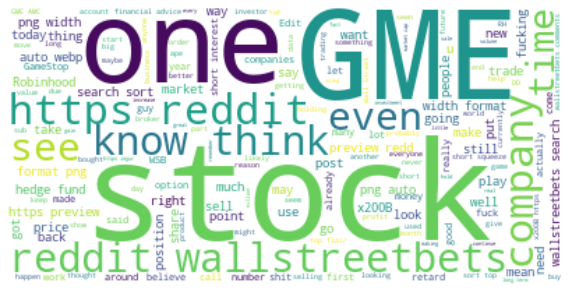

In [217]:
# Create stopword list
stopwords = set(STOPWORDS)
stopwords.update(nltk.corpus.stopwords.words('english'))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [207]:
# Visualize GME stock prices over time
fig = px.line(df_gme, x='Date', y='Adj Close', title='"GME Stock Prices over Time")
fig.show()